In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam

from glob import glob

monet_path = ("gan-getting-started/monet_jpg")
photo_path = ("gan-getting-started/photo_jpg")

### Week 5: Monet Painting Generation

#### Problem
This project involves analyzing various paintings by Monet and creating an ML model that can modify photos to have a similar aesthetic as Monet's paintings. This data is sourced from https://www.kaggle.com/competitions/gan-getting-started/overview, containing 300 paintings by Monet, as well as various photos to try and stylize.

#### EDA
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

First, I'll take a look at the provided Monet images. There are 300 images total, all of them 256x256 images.

Total images:  300
Image sizes:  {(256, 256)}


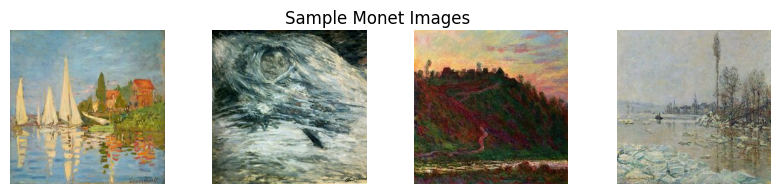

In [59]:
monet_images = glob(monet_path + "/*.jpg")

def image_sample(images, title):
    print("Total images: ", len(images))
    
    plt.figure(figsize=(10, 2))
    
    size_set = set()

    for image in images:
        img = load_img(image)
        size_set.add(img.size)
    
    for i, img_path in enumerate(images[:4]):
        img = load_img(img_path)    
        plt.subplot(1, 4, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
    
    plt.suptitle(f'Sample {title} Images') 
    
    print("Image sizes: ", size_set)
    
    plt.show()

image_sample(monet_images, "Monet")

I'll take a look at the Photos as well. There's 7038 total, all 256x256 images again, so I won't need to resize any images.

Total images:  7038
Image sizes:  {(256, 256)}


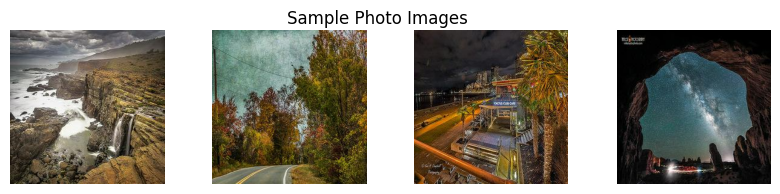

In [60]:
photo_images = glob(photo_path + "/*.jpg")
image_sample(photo_images, "Photo")

Next, I'll preprocess the training images (I want to normalize the values and set the batch size), and create the training dataset.

In [111]:
def load_images(path):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(256, 256),
        batch_size=30, #from 32
        label_mode=None 
    )
    dataset = dataset.map(lambda x: (x / 127.5) - 1.0)  # Normalize to [-1, 1]
    return dataset

train_dataset = load_images(monet_path)

# Verifying it works
# for batch in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         plt.subplot(3, 3, i + 1)
#         plt.imshow((batch[i] + 1) / 2)  # Rescale back to [0, 1] for visualization
#         plt.axis('off')
#     plt.show()

Found 300 files.


#### Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

In [ ]:
# Build Autoencoder

In [1]:
# Build Decoder

Building the generator component for the GAN. The goal is to take in random noise as an input, and then upsample into a 256x256x3 image as output.

In [112]:
# Build Generator
def build_gen(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(16 * 16 * 512, use_bias=False, input_shape=(latent_dim,), kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((16, 16, 512)),
    
        # Need to Upsample to 128x128    
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (32, 32, 256) Shape

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (64, 64, 128)

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (128, 128, 64)

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (256, 256, 32)

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh')  # (256, 256, 3)
    ])
    return model

latent_dim = 100
generator = build_gen(latent_dim)
generator.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 131072)         │    13,107,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 32, 32, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_44             │ (None, 64, 64, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 128, 128, 64)   │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (None, 256, 256, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (None, 256, 256, 3)    │         2,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,987,811 (68.62 MB)

 Trainable params: 17,724,707 (67.61 MB)

 Non-trainable params: 263,104 (1.00 MB)

Similarly, the discriminator needs to take in a 256x256x3 image, and determine if it's real or fake.

In [113]:
# Build Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        # layers.LeakyReLU(),
        # layers.Dropout(0.3),

        # layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        # layers.LeakyReLU(),
        # layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid') 
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,081 (2.80 MB)

 Trainable params: 734,081 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

Initializingi the optimizers (using Adam, with 0.0001 learning rate to start off), and setting up the loss functions for the generator and discriminator.

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Copied from Week 4, might not apply.

In [114]:
# Model Compilation

generator_optimizer = Adam(learning_rate=0.00001)
discriminator_optimizer = Adam(learning_rate=0.00001)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fool discriminator

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss



Defining the training loop for the GAN (Generating real and fake images, and passing to the discriminator to train) 

In [115]:
def train_step(images, generator, discriminator, latent_dim):
    noise = tf.random.normal([images.shape[0], latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, generator, discriminator, latent_dim):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, latent_dim)

        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

train(train_dataset, 25, generator, discriminator, latent_dim)

Epoch 1, Gen Loss: 1.5272185802459717, Disc Loss: 0.9480469822883606
Epoch 2, Gen Loss: 1.7700203657150269, Disc Loss: 0.6454484462738037
Epoch 3, Gen Loss: 1.7810943126678467, Disc Loss: 0.43519797921180725
Epoch 4, Gen Loss: 1.9321438074111938, Disc Loss: 0.28795745968818665


2024-12-05 23:55:07.362033: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Gen Loss: 2.0650644302368164, Disc Loss: 0.30914270877838135
Epoch 6, Gen Loss: 2.0052380561828613, Disc Loss: 0.2965586185455322
Epoch 7, Gen Loss: 2.1942789554595947, Disc Loss: 0.39094436168670654
Epoch 8, Gen Loss: 2.145362615585327, Disc Loss: 0.29568254947662354
Epoch 9, Gen Loss: 2.3148844242095947, Disc Loss: 0.2211984395980835
Epoch 10, Gen Loss: 2.4674346446990967, Disc Loss: 0.14654889702796936
Epoch 11, Gen Loss: 2.61862850189209, Disc Loss: 0.13795506954193115
Epoch 12, Gen Loss: 2.9007060527801514, Disc Loss: 0.11710897088050842
Epoch 13, Gen Loss: 2.5979275703430176, Disc Loss: 0.173909991979599
Epoch 14, Gen Loss: 2.8790090084075928, Disc Loss: 0.13390475511550903
Epoch 15, Gen Loss: 2.9534432888031006, Disc Loss: 0.11995284259319305
Epoch 16, Gen Loss: 3.0099244117736816, Disc Loss: 0.08215071260929108
Epoch 17, Gen Loss: 3.186807870864868, Disc Loss: 0.12235496938228607
Epoch 18, Gen Loss: 3.0225517749786377, Disc Loss: 0.15345537662506104
Epoch 19, Gen Loss:

2024-12-06 00:11:54.768046: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21, Gen Loss: 3.253619909286499, Disc Loss: 0.07659140229225159
Epoch 22, Gen Loss: 3.0947744846343994, Disc Loss: 0.1550440639257431
Epoch 23, Gen Loss: 2.9973649978637695, Disc Loss: 0.1699344962835312
Epoch 24, Gen Loss: 3.074310302734375, Disc Loss: 0.13643549382686615
Epoch 25, Gen Loss: 2.942584991455078, Disc Loss: 0.14502781629562378


#### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

tf.Tensor(-0.99984, shape=(), dtype=float32) tf.Tensor(0.9997075, shape=(), dtype=float32)


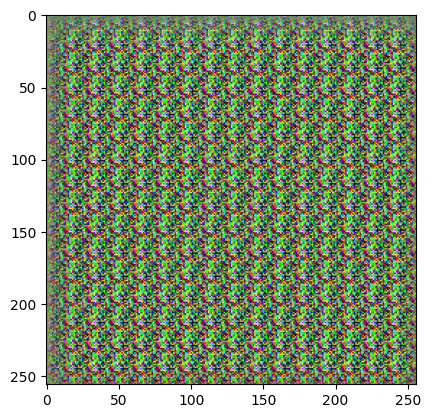

In [116]:
def generate_and_save_images(generator, epoch, latent_dim, num_examples=16):
    noise = tf.random.normal([num_examples, latent_dim])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2  # Rescale from [-1,1] (tanh output) to [0, 1]

    plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# generate_and_save_images(generator, 1, latent_dim)
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)
print(tf.reduce_min(generated_image), tf.reduce_max(generated_image))  # Check value range
plt.imshow((generated_image[0] + 1) / 2)  # Rescale and visualize

Noise Min: -3.659577 Noise Max: 3.3023834


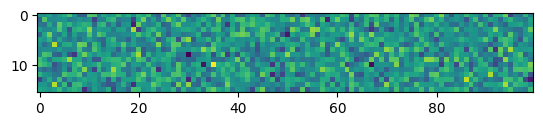

In [92]:
noise = tf.random.normal([16, latent_dim])
print("Noise Min:", tf.reduce_min(noise).numpy(), "Noise Max:", tf.reduce_max(noise).numpy())
plt.imshow((noise + 1) / 2)
